### Football, better known as  soccer in the US and Canada, is Arguably the most popular sports in the world. Thus, it is necessary to make the most out of the game by carefully analyzing  matches, and to help improve the quality of the sport and the entertainment it brings.
### In this task, I will be predicting the outcome of a game (win, draw, or lose) by the home team by carefully considering previous matches and other relevant infomation that might be helpful.
### I was provided with the European Soccer Database that can be found at https://www.kaggle.com/datasets/hugomathien/soccer  for this analysis.

## NoteBook Imports

In [192]:
import numpy as np
import pandas as pd
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Dataset import and preprocessing

In [193]:
database = './database.sqlite'

conn = sqlite3.connect(database)

#### The database contains 9 tables as listed below, but I won't be using all the tables for this purpose. Only the relevent tables and columns will be considered.
##### 1. Country:	A table containing the country name of soccer teams
##### 2. League:	A table containing the name of all the soccer leagues
##### 3. Match:	A table containing all the match details from 2007 to 2016
##### 4. Player: A table containing all player ID and player name for all the teams
##### 5. Player Attributes:	A table containing additional information of all the players such as attacking ability, defensive ability, strength, etc.
##### 6. Team:	A table containing all the team ID and team name
##### 7. Team Attributes: A table containing additional information of all the teams such as their attacking and defensive ability, etc.

### I decided to focus my analysis on the English Premiere League since it is arguably the most followed League in the world.

In [224]:
dataset = pd.read_sql("""SELECT 
                            Match.id,             
                            League.name AS league_name, 
                            season, 
                            stage, 
                            date,
                            HT.team_long_name AS  home_team,
                            AT.team_long_name AS away_team,
                            home_team_goal, 
                            away_team_goal                                        
                        FROM Match
                        JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE Country.name = 'England'
                                
                                ORDER by date;
                                """, conn)

In [274]:
dataset.head(10)

,id,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
1,1731,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1
2,1732,England Premier League,2008/2009,1,2008-08-16 00:00:00,West Ham United,Wigan Athletic,2,1
3,1734,England Premier League,2008/2009,1,2008-08-16 00:00:00,Everton,Blackburn Rovers,2,3
4,1735,England Premier League,2008/2009,1,2008-08-16 00:00:00,Middlesbrough,Tottenham Hotspur,2,1
5,1736,England Premier League,2008/2009,1,2008-08-16 00:00:00,Bolton Wanderers,Stoke City,3,1
6,1737,England Premier League,2008/2009,1,2008-08-16 00:00:00,Hull City,Fulham,2,1
7,1729,England Premier League,2008/2009,1,2008-08-17 00:00:00,Manchester United,Newcastle United,1,1
8,1733,England Premier League,2008/2009,1,2008-08-17 00:00:00,Aston Villa,Manchester City,4,2
9,1738,England Premier League,2008/2009,1,2008-08-17 00:00:00,Chelsea,Portsmouth,4,0


In [275]:
dataset.isnull().sum()

id                0
league_name       0
season            0
stage             0
date              0
home_team         0
away_team         0
home_team_goal    0
away_team_goal    0
dtype: int64

#### As can be observed, the chosen data does not contain any null values in any of the columns I have decided to use for the analysis. The most important features in this regard are the 'home_team_goal' and 'away_team_goal' features, as they determine the outcome of a match. Since the dataset is clean, let's run some statistics on the dataset.

In [276]:
dataset.describe()

,id,stage,home_team_goal,away_team_goal
count,3040.000000,3040.00000,3040.000000,3040.000000
mean,3248.500000,19.50000,1.550987,1.159539
std,877.716735,10.96766,1.311615,1.144629
min,1729.000000,1.00000,0.000000,0.000000
25%,2488.750000,10.00000,1.000000,0.000000
50%,3248.500000,19.50000,1.000000,1.000000
75%,4008.250000,29.00000,2.000000,2.000000
max,4768.000000,38.00000,9.000000,6.000000


## Discussion of the Dataset statistics
### From the results of the above cell, it can be seen that, on average, a home team scores roughly 1.6 (2) goals per game, whilst an away team scores 1.2 (1) goal per game. The first thing I can make out this statistics is that, home teams turn to have a higher chance of winning a game since they turn to score more goals than the away team. In addittion, the maximum number of goals scored by a home team is 9, whiles that of an away team is 6. 75% of the time, both the home and away teams score two goals. This however, does not directly imply that 75% of the time, matches end in a draw. Lastly, the values of the std let's us know that, the goals scored by  home teams has higher variance than that of  away. The goals scored by away teams are very close to each other in numbers. Althogh goals scored by home teams are also closer to each other (std of 1.311), they are not as close to each other as that of away teams.

### The dataset presented above gives us some insight, but it would be nice to have a subset of the dataset that will only show us a summary of these insights (create a score board). Let's do that next!

In [277]:
d = dataset[["home_team","away_team","season","home_team_goal","away_team_goal"]]

d_sumry=pd.DataFrame({"HomeTeam":d.home_team + " (" + d.season + ")", "FTHG":d.home_team_goal,  
                      "FTAG":d.away_team_goal, "AwayTeam":d.away_team + " (" + d.season + ")"})
# Note: FTHG means full time home goal (score of home team at full time) 
#  And  FTAG means full time away goal (score of away team at full time)

d_sumry.tail()

,HomeTeam,FTHG,FTAG,AwayTeam
3035,Stoke City (2015/2016),2,1,West Ham United (2015/2016)
3036,Swansea City (2015/2016),1,1,Manchester City (2015/2016)
3037,Watford (2015/2016),2,2,Sunderland (2015/2016)
3038,West Bromwich Albion (2015/2016),1,1,Liverpool (2015/2016)
3039,Manchester United (2015/2016),3,1,Bournemouth (2015/2016)


### To proceed from here, we neeed to find:
### 1. The average number of goals scored by the home team per season
### 2. The average number of goals scored by the  home team against a particular team in a given season
### 3. The average number of goals scored by the away team  per season
### 4. The average number of goals scored by the away team against a particular team in a given season. 

### To break it down, we need to find the average goal scoring record of both home and away teams each season, as well as the average goals scored against each team. When a match is to be played, we will use the average goal scoring record of the season as well as the goal scoring record against thier opponent to predict the outcome of the game.

### Having explained that, It's time to write some code to accomplish it. Let's get it going...

In [281]:
# Please note the meaning of the following abbreviations
'''
    1. HTAGS = home team average goals scored per season 
    2. HTAGT = home team average goals scored per team
    3. ATAGT = Away team average goals scored per team
    4. ATAGS = Away team average goals scored per season
'''
# home team goals average
d_sumry['HTAGS'] = d_sumry['FTHG'].groupby(d_sumry['HomeTeam']).transform('mean') 

# average goals scored against the away team in a given season
d_sumry['HTAGT'] = d_sumry['FTHG'].groupby(d_sumry['AwayTeam']).transform('mean') 

# Average goals scored against the home team in a given season
d_sumry['ATAGT'] = d_sumry['FTAG'].groupby(d_sumry['HomeTeam']).transform('mean') 
# away team goal average
d_sumry['ATAGS'] = d_sumry['FTAG'].groupby(d_sumry['AwayTeam']).transform('mean') 

d_sumry.sort_values(['HomeTeam', 'AwayTeam']).head(10)


,HomeTeam,FTHG,FTAG,AwayTeam,HTAGS,HTAGT,ATAGT,ATAGS
120,Arsenal (2008/2009),0,2,Aston Villa (2008/2009),1.631579,1.421053,0.842105,1.421053
280,Arsenal (2008/2009),4,0,Blackburn Rovers (2008/2009),1.631579,1.947368,0.842105,0.947368
198,Arsenal (2008/2009),1,0,Bolton Wanderers (2008/2009),1.631579,1.684211,0.842105,1.052632
357,Arsenal (2008/2009),1,4,Chelsea (2008/2009),1.631579,0.631579,0.842105,1.842105
70,Arsenal (2008/2009),3,1,Everton (2008/2009),1.631579,0.894737,0.842105,1.263158
259,Arsenal (2008/2009),0,0,Fulham (2008/2009),1.631579,0.947368,0.842105,0.578947
50,Arsenal (2008/2009),1,2,Hull City (2008/2009),1.631579,1.473684,0.842105,1.105263
174,Arsenal (2008/2009),1,1,Liverpool (2008/2009),1.631579,0.736842,0.842105,1.894737
299,Arsenal (2008/2009),2,0,Manchester City (2008/2009),1.631579,1.684211,0.842105,0.947368
109,Arsenal (2008/2009),2,1,Manchester United (2008/2009),1.631579,0.578947,0.842105,1.315789


In [259]:
d_sumry.shape

(3040, 8)

### We are edging closer to predicting the outcome of the games, but our dataset has no target values yet. But that shouldn't be a program becuase we can create  target values from the outcome of the games. Since our main aim is to predict whether the home team, wins, draws, or loses the game, let's loop through the dataset and create an array that will have the following values and their implications.
#### 1. if w = 1, it means the home team won the match
#### 2. if w = 0, it means the game ended in a draw
#### 3. if w = -1, it means the home team lost the match.
### Let's get this done too...

In [260]:
# an array to keep the records of the outcome of games
outcome = []

for g in range(0, len(d_sumry)):
    if(d_sumry['FTHG'][g] > d_sumry['FTAG'][g]):
        r = 1
        outcome.append(r)
    elif(d_sumry['FTHG'][g] == d_sumry['FTAG'][g]):
        r = 0
        outcome.append(r)
    else:
        r = -1
        outcome.append(r)
        
# Since we now have our target values, Let's create a new dataset out of the existing one to include the target values.

data = pd.DataFrame({"HTAGS":d_sumry['HTAGS'],"HTAGT":d_sumry['HTAGT'],
                     "ATAGT":d_sumry['ATAGT'],"ATAGS":d_sumry['ATAGS'],"result":outcome})
data.head()

,HTAGS,HTAGT,ATAGT,ATAGS,result
0,1.631579,1.789474,0.842105,0.526316,1
1,1.105263,0.736842,1.315789,1.894737,-1
2,1.210526,1.421053,1.157895,0.894737,1
3,1.631579,1.947368,1.052632,0.947368,-1
4,0.894737,1.842105,1.052632,1.263158,1


In [261]:
data.shape  # to confirm indeed, the dataset hasn't changed

(3040, 5)

In [262]:
type(data)

pandas.core.frame.DataFrame

### Now that we have the dataset in the form that we want, we can create our model. There are tons of models available for selection, but I will go for Sklearn's KNeighbors Model. It is flexible to work with, and I think for this particular task, its performance will be particularly appreciable. I will be using 80% of the dataset to train the model and the rest for testing.

In [263]:
target = data.iloc[:, -1]
X_data = data.iloc[:, 0:4]

# Split dataset into training set and testing set

X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.20, random_state=15)

In [264]:
# creating the model
#kfold = model_selection.KFold(n_splits=2)
model = KNeighborsClassifier(n_neighbors = 201, metric = 'minkowski', p = 1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.89%


### Calculating and analysing the confusion matrix

In [265]:
conf_mat = confusion_matrix(y_test, predictions)

In [266]:
conf_mat

array([[ 92,  11,  78],
       [ 42,   9,  81],
       [ 34,  10, 251]], dtype=int64)

In [267]:
cm_df = pd.DataFrame(conf_mat,
                     index = ['Lose','Draw','Win'], 
                     columns = ['Lose','Draw','Win'])

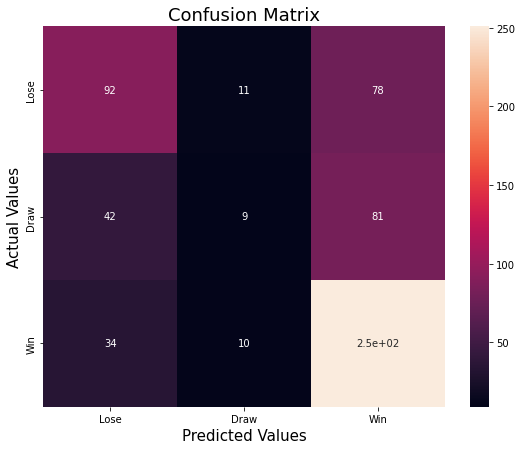

In [268]:
#Plotting the confusion matrix
plt.figure(figsize=(9,7))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix', fontdict={'fontsize': 18})
plt.ylabel('Actual Values', fontdict={'fontsize': 15})
plt.xlabel('Predicted Values', fontdict={'fontsize': 15})
plt.show()